# Data Science Regression Project: Predicting Home Prices in Banglore

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)

## Data Load: Load banglore home prices into a dataframe

In [4]:
df1 = pd.read_csv("bengaluru_house_prices_data.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [5]:
df1.shape

(13320, 9)

In [6]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

## Drop features that are not required to build our model

In [7]:
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.shape

(13320, 5)

## Data Cleaning: Handle NA values

In [8]:
df2.isnull().sum()

,0
location,1
size,16
total_sqft,0
bath,73
price,0


In [9]:
df2.shape

(13320, 5)

In [10]:
df3 = df2.dropna()
df3.isnull().sum()

,0
location,0
size,0
total_sqft,0
bath,0
price,0


In [11]:
df3.shape

(13246, 5)

## Feature Engineering

**Add new feature(integer) for bhk (Bedrooms Hall Kitchen)**

In [12]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

/tmp/ipython-input-2716584372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

#### Explore total_sqft feature

In [13]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [14]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


#### Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple

In [15]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [16]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


#### Add new feature called price per square feet

In [17]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [18]:
df5['price_per_sqft'].describe()

,price_per_sqft
count,1.320000e+04
mean,7.920759e+03
std,1.067272e+05
min,2.678298e+02
25%,4.267701e+03
50%,5.438331e+03
75%,7.317073e+03
max,1.200000e+07


In [19]:
df5.to_csv("data.csv",index=False)

#### Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations

In [20]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

,count
location,
Whitefield,533
Sarjapur Road,392
Electronic City,304
Kanakpura Road,264
Thanisandra,235
...,...
Zuzuvadi,1
Chellikere,1
Jakkasandra,1


In [21]:
location_stats.values.sum()

np.int64(13200)

In [22]:
len(location_stats[location_stats>10])

240

In [23]:
len(location_stats)

1287

In [24]:
len(location_stats[location_stats<=10])

1047

## Dimensionality Reduction

#### Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [25]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

,count
location,
Ganga Nagar,10
Kalkere,10
Dairy Circle,10
1st Block Koramangala,10
Sector 1 HSR Layout,10
...,...
Zuzuvadi,1
Chellikere,1
Jakkasandra,1


In [26]:
len(df5.location.unique())

1287

In [27]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

241

In [28]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


## Outlier Removal

#### Normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft

In [29]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


#### We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely

In [30]:
df5.shape

(13200, 7)

In [31]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12456, 7)

#### Outlier Removal Using Standard Deviation and Mean

In [32]:
df6.price_per_sqft.describe()

,price_per_sqft
count,12456.000000
mean,6308.502826
std,4168.127339
min,267.829813
25%,4210.526316
50%,5294.117647
75%,6916.666667
max,176470.588235


#### Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [33]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(10242, 7)

#### Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like

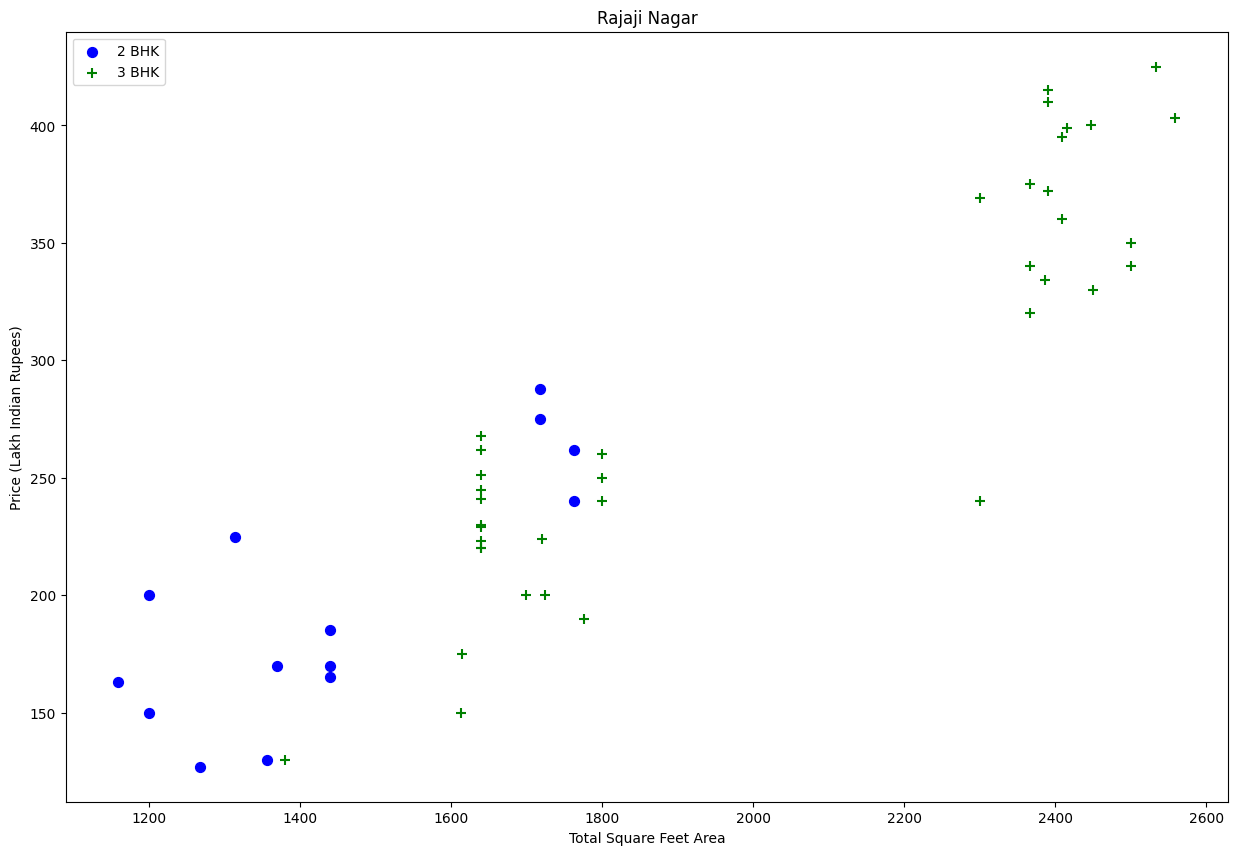

In [34]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()

plot_scatter_chart(df7,"Rajaji Nagar")

#### We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area).
#### Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment**

In [35]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

(7317, 7)

#### Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties

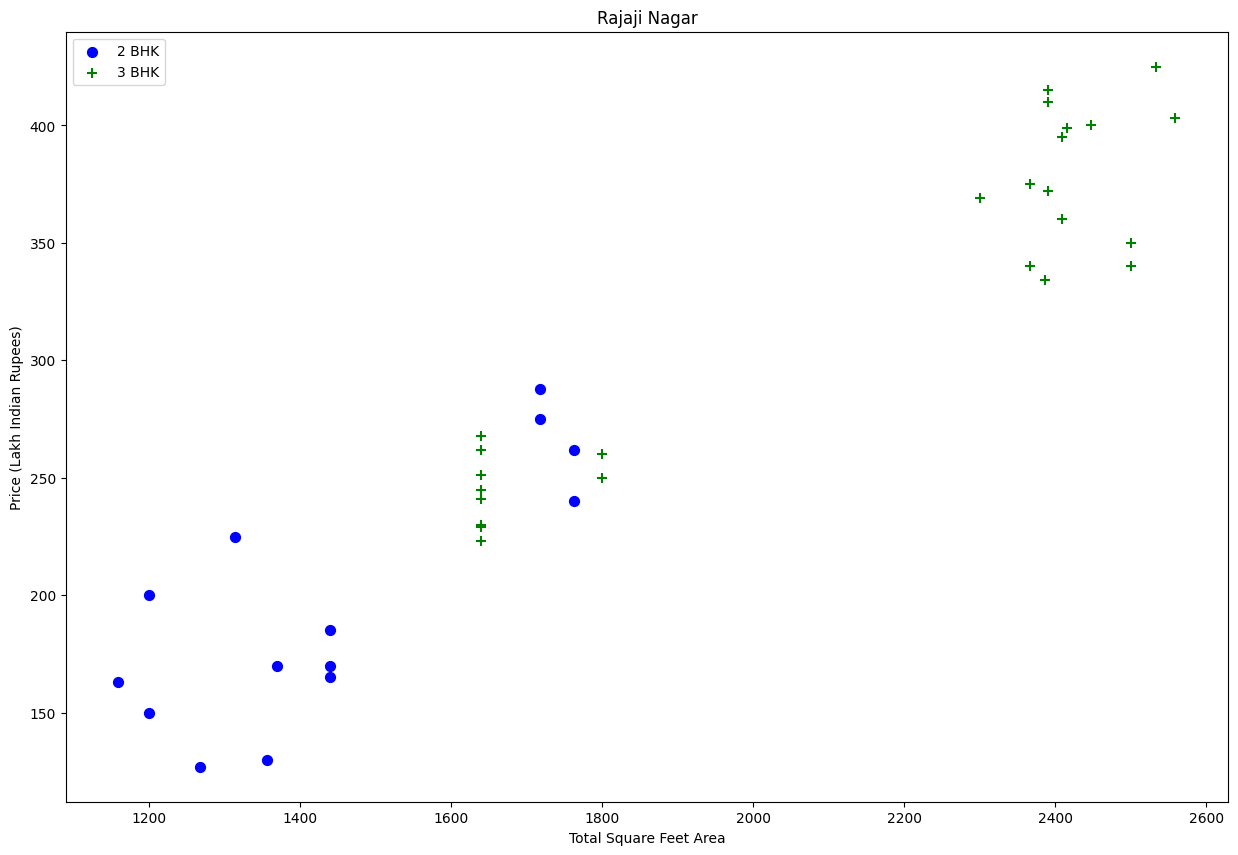

In [36]:
plot_scatter_chart(df8,"Rajaji Nagar")

Text(0, 0.5, 'Count')

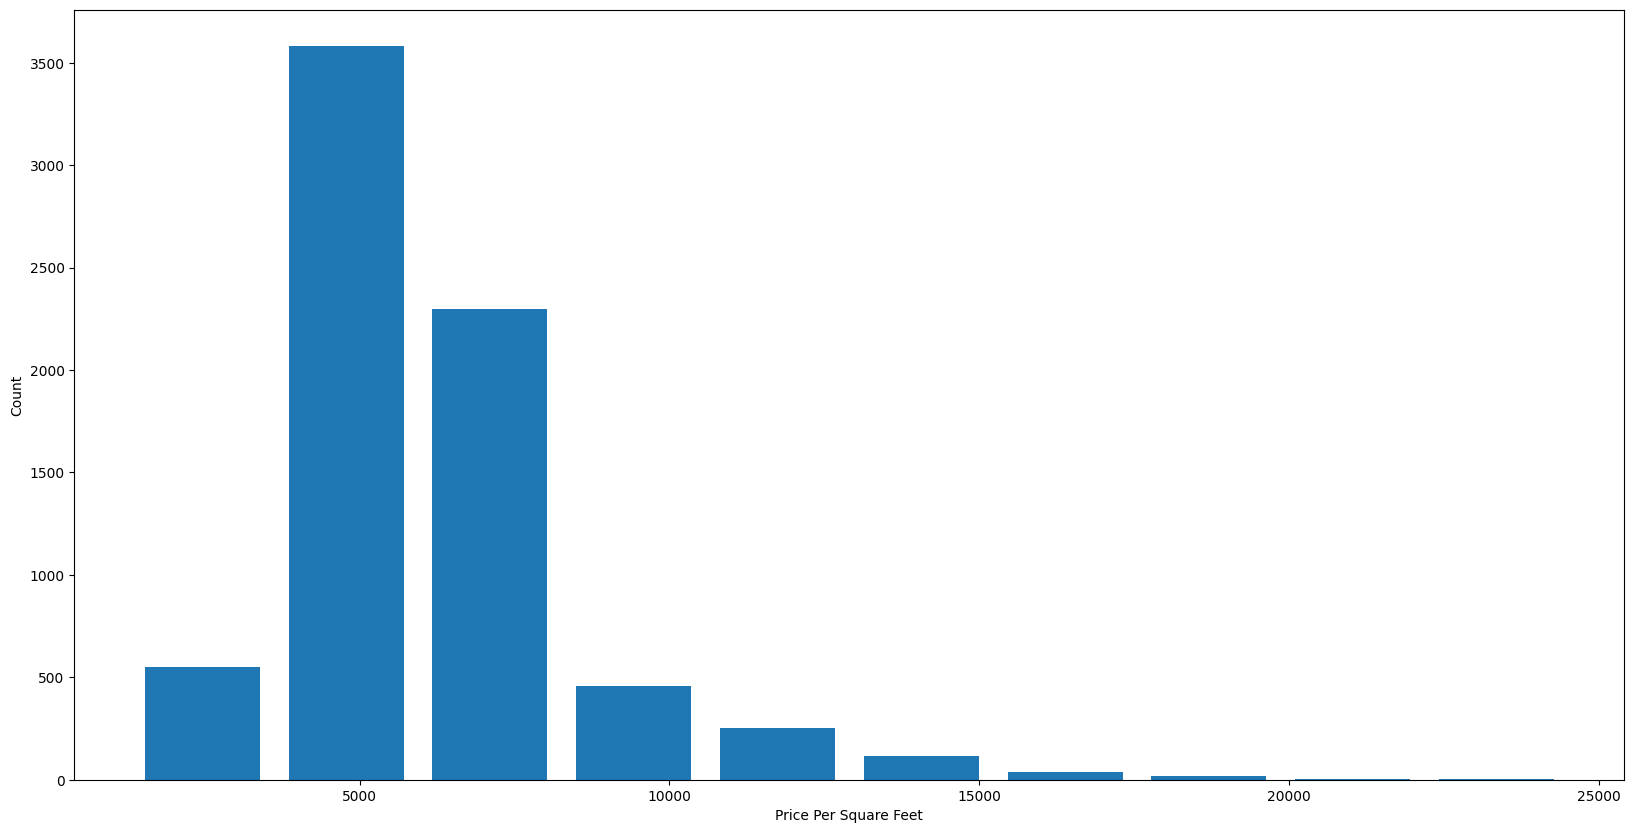

In [37]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

## Outlier Removal Using Bathrooms Feature

In [38]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

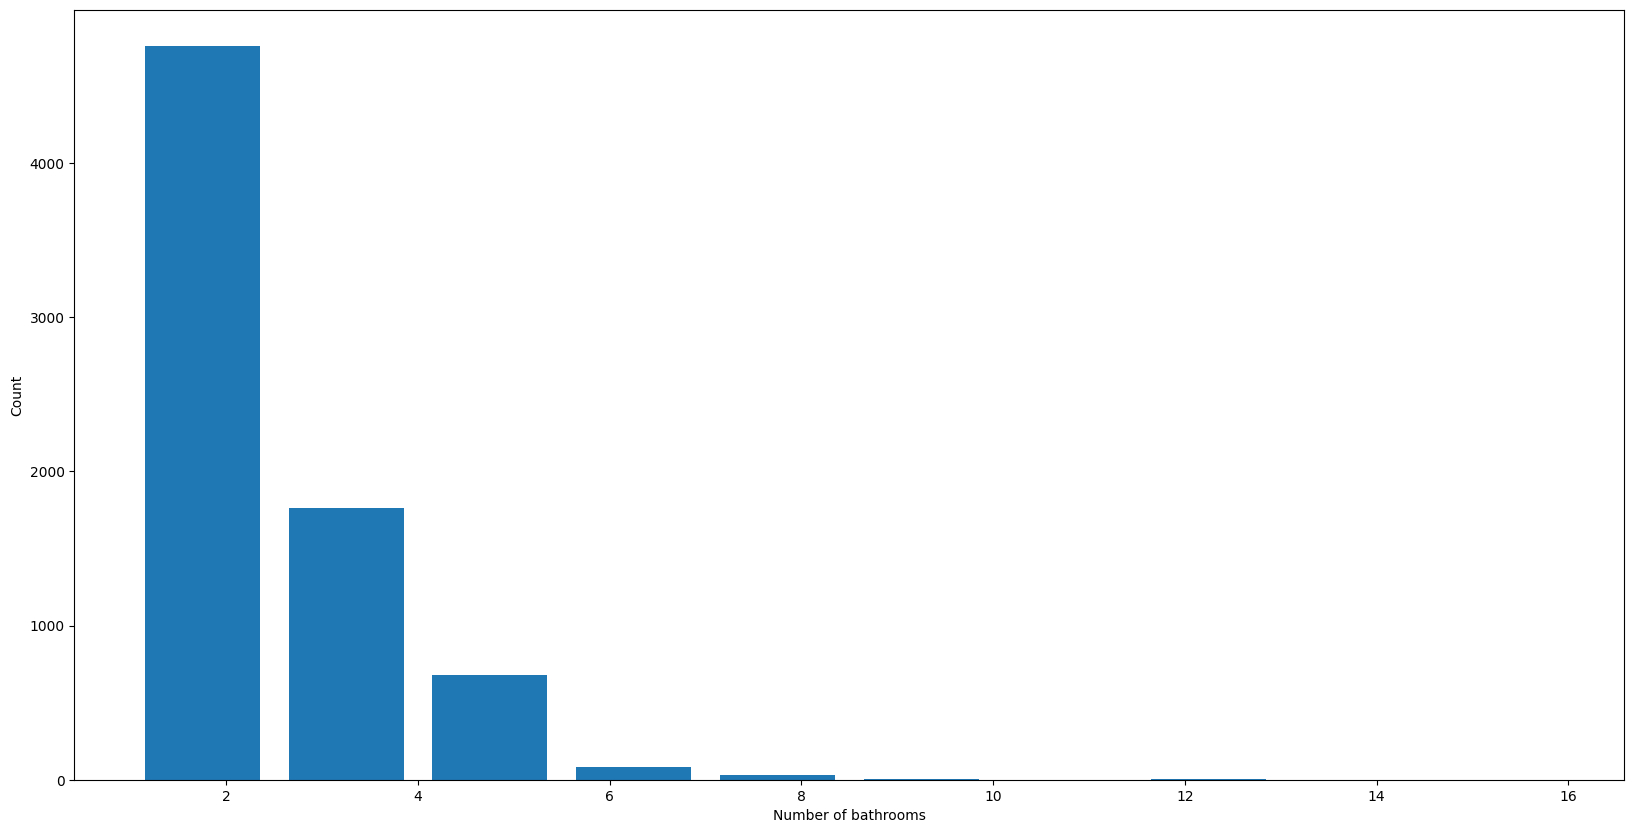

In [39]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [40]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8483,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8572,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9306,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9637,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


#### It is unusual to have 2 more bathrooms than number of bedrooms in a home

In [41]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8408,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


#### If you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed

In [42]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(7239, 7)

In [43]:
df9.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668


In [44]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


#### Use One Hot Encoding For Location

In [45]:
dummies = pd.get_dummies(df10.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [46]:
df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1st Block Jayanagar,1630.0,3.0,194.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1st Block Jayanagar,1875.0,2.0,235.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1st Block Jayanagar,1200.0,2.0,130.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1st Block Jayanagar,1235.0,2.0,148.0,2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [47]:
df12 = df11.drop('location',axis='columns')
df12.head(2)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,194.0,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Build a Model

In [48]:
df12.shape

(7239, 244)

In [49]:
X = df12.drop(['price'],axis='columns')
X.head()

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1875.0,2.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1200.0,2.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1235.0,2.0,2,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [50]:
X.shape

(7239, 243)

In [51]:
y = df12.price
y.head()

,price
0,428.0
1,194.0
2,235.0
3,130.0
4,148.0


In [52]:
len(y)

7239

## Train the models

### Train individual models

In [53]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#models
lr_model = LinearRegression()
lasso_model = Lasso(alpha=2, selection='cyclic')
dt_model = DecisionTreeRegressor(criterion='friedman_mse', splitter='best')
rf_model = RandomForestRegressor(n_estimators=50)
svm_model = make_pipeline(StandardScaler(), SVR(C=100, kernel='linear'))  # SVM needs scaling

models = {
    'Linear Regression': lr_model,
    'Lasso Regression': lasso_model,
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'SVM': svm_model
}

# ShuffleSplit CV
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
results = []

for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)

    # Test set score
    test_score = model.score(X_test, y_test)

    # Cross-validation score
    cv_scores = cross_val_score(model, X, y, cv=cv)
    cv_mean = np.mean(cv_scores)

    results.append({
        'Model': name,
        'Test R2 Score': round(test_score, 4),
        'CV Mean R2': round(cv_mean, 4)
    })

results_df = pd.DataFrame(results)
print(results_df)


               Model  Test R2 Score  CV Mean R2
0  Linear Regression         0.7972      0.8478
1   Lasso Regression         0.6886      0.7267
2      Decision Tree         0.6488      0.7167
3      Random Forest         0.7039      0.7808
4                SVM         0.7946      0.8429


In [54]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Define and train
xgb_model = XGBRegressor(
    n_estimators=200,   # number of trees
    learning_rate=0.05, # smaller = slower but more accurate
    max_depth=5,        # control model complexity
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R2: {r2:.3f}, MAE: {mae:.3f}, RMSE: {rmse:.3f}")


R2: 0.674, MAE: 18.713, RMSE: 55.055


In [55]:
# Linear Regression
lr_clf = make_pipeline(StandardScaler(), LinearRegression())
lr_clf.fit(X_train, y_train)

# Lasso Regression
lasso_clf = make_pipeline(StandardScaler(), Lasso(alpha=2, selection='cyclic'))
lasso_clf.fit(X_train, y_train)

# Decision Tree
dt_clf = DecisionTreeRegressor(criterion='friedman_mse', splitter='best')
dt_clf.fit(X_train, y_train)

# Support Vector Machine
svm_clf = make_pipeline(StandardScaler(), SVR(C=100, kernel='linear'))
svm_clf.fit(X_train, y_train)

# Random Forest
rf_clf = RandomForestRegressor(n_estimators=50)
rf_clf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=50)

#### Test the model

In [56]:
def predict_price(location, sqft, bath, bhk, model):
    try:
        loc_index = np.where(X.columns == location)[0][0]
    except IndexError:
        loc_index = -1

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk

    if loc_index >= 0:
        x[loc_index] = 1

    # Fix: convert to DataFrame with column names
    import pandas as pd
    x_df = pd.DataFrame([x], columns=X.columns)

    predicted_price = model.predict(x_df)[0]
    print(f'Predicted price:')
    return predicted_price


In [57]:
print('Linear Regression:')
print(predict_price('1st Phase JP Nagar',1000, 2, 2, model = lr_model))
print('Lasso Regression:')
print(predict_price('1st Phase JP Nagar',1000, 2, 2, model=lasso_clf))
print('SVM:')
print(predict_price('1st Phase JP Nagar',1000, 2, 2, model=svm_clf))
print('Decision Tree:')
print(predict_price('1st Phase JP Nagar',1000, 2, 2, model=dt_clf))
print('Random Forest:')
print(predict_price('1st Phase JP Nagar',1000, 2, 2, model=rf_clf))

Linear Regression:
Predicted price:
97.21063159901126
Lasso Regression:
Predicted price:
55.2585853794791
SVM:
Predicted price:
87.40339004118353
Decision Tree:
Predicted price:
93.0
Random Forest:
Predicted price:
81.13213958263958


#### Export the tested model to a pickle file

In [58]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

#### Export location and column information to a file that will be useful later on in our prediction application

In [59]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))

## Stack Classifier

In [60]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Base regressors
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)),
    ('svr', SVR(C=1.0, kernel='rbf')),
    ('knn', KNeighborsRegressor(n_neighbors=5))
]

# Meta-model (final estimator)
meta_model = LinearRegression()

# Stacking Regressor
stack_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model,
    passthrough=True,
    cv=5
)

# Build pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', stack_reg)
])


# Train the model
pipe.fit(X_train, y_train)


# Predictions
y_pred = pipe.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


R² Score: 0.7897
MSE: 1953.6156
RMSE: 44.1997
MAE: 15.6976


In [61]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
from xgboost import XGBRegressor

# Base models
estimators = [
    ('lr', LinearRegression()),
    ('lasso', Lasso(alpha=0.001, random_state=42)),
    ('dt', DecisionTreeRegressor(max_depth=8, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)),
    ('svm', SVR(C=1.0, kernel='rbf')),
    ('xgb', XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective='reg:squarederror'
    ))
]


# Meta model (final estimator)
meta_model = LinearRegression()

# Stacking Regressor
stack_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model,
    passthrough=True,
    cv=5
)


# Build pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('stack', stack_reg)
])


# Train the model
pipe.fit(X_train, y_train)


# Predictions
y_pred = pipe.predict(X_test)


# Evaluation Metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("Model Evaluation Results")
print(f"R2 Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


Model Evaluation Results
R2 Score: 0.7893
MSE: 1957.2675
RMSE: 44.2410
MAE: 17.4993


In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Base models
estimators = [
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators=150, max_depth=10, random_state=42)),
    ('svm', SVR(C=1.0, kernel='rbf')),
    ('knn', KNeighborsRegressor(n_neighbors=5))
]

# Nonlinear meta-model
meta_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'
)

# Stacking Regressor
stack_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model,
    passthrough=True,
    cv=5,
    n_jobs=-1
)

# Pipeline with scaling
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('stack', stack_reg)
])

# Train
pipe.fit(X_train, y_train)

# Predict
y_pred = pipe.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("Optimized Stacking Regressor Performance:")
print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


Optimized Stacking Regressor Performance:
R2 Score: 0.7265
MAE: 14.2450
RMSE: 50.4115


In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Base models
estimators = [
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators=150, max_depth=10, random_state=42)),
    ('knn', KNeighborsRegressor(n_neighbors=5))
]

# Nonlinear meta-model
meta_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'
)

# Stacking Regressor
stack_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model,
    passthrough=True,  # meta-model sees original features + base predictions
    cv=5,
    n_jobs=-1
)

# Pipeline with scaling (important for KNN)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('stack', stack_reg)
])

# Train
pipe.fit(X_train, y_train)

# Predict
y_pred = pipe.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(" Ensemble Carefully - Stacking Regressor Results:")
print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


 Ensemble Carefully - Stacking Regressor Results:
R² Score: 0.7199
MAE: 14.3848
RMSE: 51.0162


In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build NN model
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train
history = model.fit(X_train_scaled, y_train, validation_split=0.2,
                    epochs=200, batch_size=32, verbose=1)

# Predict
y_pred_nn = model.predict(X_test_scaled).flatten()

# Evaluate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2_nn = r2_score(y_test, y_pred_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
mae_nn = mean_absolute_error(y_test, y_pred_nn)

print(" Neural Network Performance:")
print(f"R2 Score: {r2_nn:.4f}")
print(f"MAE: {mae_nn:.4f}")
print(f"RMSE: {rmse_nn:.4f}")


Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 13348.3125 - mae: 81.5687 - val_loss: 4575.2627 - val_mae: 33.6350
Epoch 2/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2839.9097 - mae: 30.9596 - val_loss: 2930.0127 - val_mae: 23.8130
Epoch 3/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1904.8137 - mae: 23.1151 - val_loss: 2295.1108 - val_mae: 21.7749
Epoch 4/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1788.6332 - mae: 22.6439 - val_loss: 1924.8856 - val_mae: 20.4662
Epoch 5/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1433.9824 - mae: 21.1904 - val_loss: 1709.0049 - val_mae: 19.6362
Epoch 6/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1337.6664 - mae: 20.5694 - val_loss: 1775.3193 - val_mae: 19.5358
Epoch 7/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1096.3293 - mae: 19.5426 - val_loss: 1911.3206 - val_mae: 20.1925
Epoch 8/200
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1096.3507 - mae: 19.1131 - val_loss: 1882.7269 - val_mae: 18.

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np


# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Build Optimized Neural Network
model = Sequential([
    Dense(256, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='linear')
])

# Compile
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])


# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1, min_lr=1e-5)


# Train Model
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Predict & Evaluate
y_pred_nn = model.predict(X_test_scaled).flatten()

r2_nn = r2_score(y_test, y_pred_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
mae_nn = mean_absolute_error(y_test, y_pred_nn)

print("\n Optimized Neural Network Performance:")
print(f"R2 Score: {r2_nn:.4f}")
print(f"MAE: {mae_nn:.4f}")
print(f"RMSE: {rmse_nn:.4f}")


Epoch 1/500


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 15796.8945 - mae: 96.8129 - val_loss: 17270.1367 - val_mae: 95.6815 - learning_rate: 5.0000e-04
Epoch 2/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 14872.2373 - mae: 95.2642 - val_loss: 15383.7568 - val_mae: 95.4373 - learning_rate: 5.0000e-04
Epoch 3/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 14240.7822 - mae: 94.9341 - val_loss: 13805.6367 - val_mae: 94.0528 - learning_rate: 5.0000e-04
Epoch 4/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 11661.0811 - mae: 88.1630 - val_loss: 12431.1621 - val_mae: 92.4672 - learning_rate: 5.0000e-04
Epoch 5/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10842.0156 - mae: 85.3300 - val_loss: 10415.0391 - val_mae: 87.0710 - learning_rate: 5.0000e-04
Epoch 6/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9756.9072 - mae: 81.0610 - val_loss: 8620.1543 - val_mae: 80.5904 - learning_rate: 5.0000e-04
Epoch 7/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7943.2788 